In [4]:
import os
import json
import pandas as pd

# Thay đường dẫn này bằng đúng đường dẫn thư mục bạn đã lưu các file JSON
data_dir = r'C:\Users\Vinh Thuan\Documents\GitHub\VectorHub\docs\tools\vdb_table\data'

# Danh sách chứa dữ liệu từ tất cả các file
records = []

# Lặp qua tất cả các file JSON trong thư mục
for filename in os.listdir(data_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(data_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
            flat_data = {'slug': filename.replace('.json', '')}

            # Flatten dữ liệu ở cấp 1 và các giá trị trong "value" nếu có
            for key, val in data.items():
                if isinstance(val, dict) and 'value' in val:
                    flat_data[key] = val['value']
                elif isinstance(val, dict) and 'support' in val:
                    flat_data[key] = val['support']
                elif isinstance(val, list) or isinstance(val, dict):
                    flat_data[key] = str(val)  # hoặc json.dumps(val)
                else:
                    flat_data[key] = val

            records.append(flat_data)

# Tạo DataFrame
df = pd.DataFrame(records)

# Hiển thị các cột
print("Các cột có trong bảng:")
print(df.columns.tolist())

# Lưu ra file Excel (nếu muốn)
df.to_excel("vector_db_comparison.xlsx", index=False)

# Hoặc hiển thị một phần bảng
print(df.head())


Các cột có trong bảng:
['slug', 'name', 'links', 'oss', 'license', 'dev_languages', 'vector_launch_year', 'metadata_filter', 'hybrid_search', 'facets', 'geo_search', 'multi_vec', 'sparse_vectors', 'bm25', 'full_text', 'embeddings_text', 'embeddings_image', 'embeddings_structured', 'rag', 'recsys', 'langchain', 'llamaindex', 'managed_cloud', 'pricing', 'in_process', 'multi_tenancy', 'disk_index', 'ephemeral', 'sharding', 'doc_size', 'vector_dims', 'binary_quantization', 'index_types', 'github_stars', 'docker_pulls', 'pypi_downloads', 'npm_downloads', 'crates_io_downloads', 'int8_quantization']
              slug                  name  \
0       activeloop  Activeloop Deep Lake   
1        aerospike             Aerospike   
2          anariai              Anari AI   
3  apachecassandra      Apache Cassandra   
4       apachesolr           Apache Solr   

                                               links   oss      license  \
0  {'docs': 'https://docs.activeloop.ai/', 'githu...  full  

In [6]:
df.to_csv("vector_db_comparison.csv", index=False, encoding='utf-8-sig')

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv("vector_db_comparison.csv")


exclude_cols = {"slug", "name", "links","license","pricing","doc_size","index_type","vector_dims","dev_languages"}
feature_cols = [col for col in df.columns if col not in exclude_cols]


support_score_map = {"full": 1, "partial": 0.5, "none": 0, "": 0, None: 0}


def pricing_score(pricing):
    return 1 if isinstance(pricing, str) and "free" in pricing.lower() else 0


scores = []
for _, row in df.iterrows():
    total_score = 0
    count = 0
 
    total_score += pricing_score(row['pricing'])
    count += 1 if "pricing" in feature_cols else 0

    for col in feature_cols:
        val = row[col]


        if isinstance(val, (int, float)):
            continue
        elif isinstance(val, str) and val.isdigit():
            continue

        elif isinstance(val, str):
            score = support_score_map.get(val.lower(), 0)
        else:
            score = 0

        total_score += score
        count += 1

    scores.append((total_score, count))

numeric_cols = ["github_stars", "docker_pulls", "pypi_downloads", "npm_downloads", "crates_io_downloads"]
scaler = MinMaxScaler()

numeric_values = df[numeric_cols].fillna(0)
scaled = scaler.fit_transform(numeric_values)

for i in range(len(scores)):
    scaled_sum = sum(scaled[i])
    total, count = scores[i]
    scores[i] = total + scaled_sum, count + len(numeric_cols)

df_scores = df[["name", "slug"]].copy()
df_scores["score_raw"] = [s[0] for s in scores]
df_scores["score_normalized_10"] = df_scores["score_raw"] / df_scores["score_raw"].max() * 10

# Sort và lấy top 10
top10 = df_scores.sort_values("score_normalized_10", ascending=False).head(10)

# In kết quả
print("🏆 Top 10 Vector DB theo tổng điểm kỹ thuật:")
print(top10[["name", "slug", "score_normalized_10"]])


🏆 Top 10 Vector DB theo tổng điểm kỹ thuật:
                    name           slug  score_normalized_10
32                Qdrant         qdrant            10.000000
13         Elasticsearch  elasticsearch             9.430077
42                 Vespa          vespa             9.144653
26            OpenSearch     opensearch             9.116129
43              Weaviate       weaviate             8.561232
6        Azure AI Search        azureai             7.561868
22         MongoDB Atlas          mongo             7.285809
0   Activeloop Deep Lake     activeloop             7.110414
21                Milvus         milvus             7.062601
23               MyScale        myscale             6.834351


In [13]:
len(feature_cols)

31

In [14]:
feature_cols

['oss',
 'vector_launch_year',
 'metadata_filter',
 'hybrid_search',
 'facets',
 'geo_search',
 'multi_vec',
 'sparse_vectors',
 'bm25',
 'full_text',
 'embeddings_text',
 'embeddings_image',
 'embeddings_structured',
 'rag',
 'recsys',
 'langchain',
 'llamaindex',
 'managed_cloud',
 'in_process',
 'multi_tenancy',
 'disk_index',
 'ephemeral',
 'sharding',
 'binary_quantization',
 'index_types',
 'github_stars',
 'docker_pulls',
 'pypi_downloads',
 'npm_downloads',
 'crates_io_downloads',
 'int8_quantization']

C:\Users\Vinh Thuan\AppData\Local\Temp\ipykernel_17852\4119375048.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='name', y='score_normalized_10', data=top10_scores, palette="viridis")


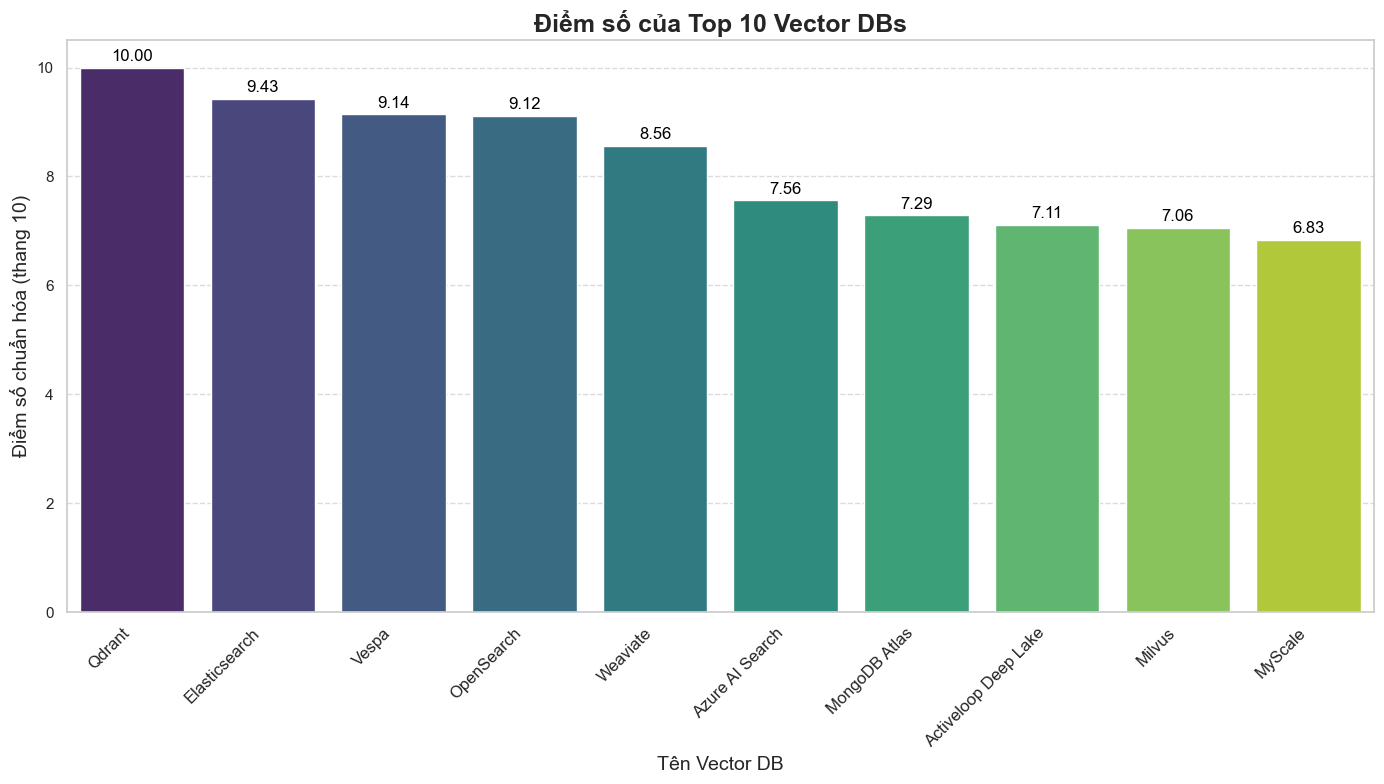

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy top 10 Vector DBs từ DataFrame
top10_scores = df_scores.sort_values('score_normalized_10', ascending=False).head(10)

# Cài đặt màu sắc đẹp cho biểu đồ
sns.set(style="whitegrid", palette="muted")

# Vẽ bar plot với màu sắc đẹp cho top 10
plt.figure(figsize=(14, 8))
plot = sns.barplot(x='name', y='score_normalized_10', data=top10_scores, palette="viridis")

# Cài đặt tiêu đề và nhãn
plt.title('Điểm số của Top 10 Vector DBs', fontsize=18, weight='bold')
plt.xlabel('Tên Vector DB', fontsize=14)
plt.ylabel('Điểm số chuẩn hóa (thang 10)', fontsize=14)

# Xoay các nhãn trên trục x cho dễ đọc
plt.xticks(rotation=45, ha="right", fontsize=12)

# Thêm gridlines nhẹ để dễ đọc hơn
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên từng thanh (điều chỉnh vị trí cho không dính nhau)
for p in plot.patches:
    # Lấy vị trí x và y của thanh
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    
    # Điều chỉnh vị trí cho các số sao cho không bị dính
    plot.annotate(f'{y:.2f}', 
                  (x, y), 
                  ha = 'center', va = 'center', 
                  fontsize=12, color='black', 
                  xytext=(0, 8), textcoords='offset points')

# Tăng khoảng cách các nhãn trục
plt.tight_layout()

# Hiển thị plot
plt.show()


Web: https://superlinked.com/vector-db-comparison

Git: https://github.com/superlinked/VectorHub/tree/main/docs/tools/vdb_table/data